In [1]:

!pip install torch torchvision
!pip install -U torchmetrics pytorch-lightning
!pip install torchmetrics
!pip install segmentation-models-pytorch
!pip install pycocotools
!pip install opencv-python-headless
!pip install albumentations==1.4.3

In [2]:
import os

#  Configurar Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#  Descargar y descomprimir datos
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation
!unzip -q brain-tumor-image-dataset-semantic-segmentation.zip

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
brain-tumor-image-dataset-semantic-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
replace README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace test/1030_jpg.rf.4bfc0ebc72d835cb9668219cd911c249.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [3]:
import numpy as np
import cv2
from PIL import Image
from pycocotools.coco import COCO
import albumentations as A

#  Imports de PyTorch
import torch
from torch.utils.data import DataLoader, IterableDataset
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics

# Definir rutas y cargar anotaciones
train_dir = '/content/train'
val_dir = '/content/valid'
test_dir = '/content/test'

train_annotation_file = '/content/train/_annotations.coco.json'
test_annotation_file = '/content/test/_annotations.coco.json'
val_annotation_file = '/content/valid/_annotations.coco.json'

train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

print("Librerías de PyTorch cargadas.")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Librerías de PyTorch cargadas.


In [9]:
import torch

def manual_dice_coef(y_true, y_pred, smooth=100, threshold=0.5):
    """
    Implementación manual de Dice Coefficient en PyTorch.
    y_true: Máscara real (float 0.0 o 1.0)
    y_pred: Predicción del modelo (float 0.0-1.0, probabilidades)
    """

    # Aplicar umbral a las predicciones
    y_pred_bin = (y_pred > threshold).float()

    # Aplanar tensores
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred_bin.view(-1)

    # Calcular intersección y unión
    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f)

    # Calcular Dice
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

In [4]:
augment = A.Compose([
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

In [5]:
from torch.utils.data import Dataset

class FullImageDataset(Dataset):
    def __init__(self, coco, image_dir, image_ids, augmentations=None):
        super().__init__()
        self.coco = coco
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.augment = augmentations
        self.target_size = (512, 512)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Cargar imagen y máscara
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((image_info['height'], image_info['width']))
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        # Redimensionar
        image_resized = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR).astype(np.uint8)
        mask_resized = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST).astype(np.uint8) # (H, W)

        # Aplicar Aumentaciones
        if self.augment:
            augmented = self.augment(image=image_resized, mask=mask_resized)
            image_resized = augmented['image']
            mask_resized = augmented['mask']

        # 4. Normalizar y Transponer (formato PyTorch)
        image_norm = image_resized.astype(np.float32) / 255.0

        # (H, W, C) -> (C, H, W)
        image_torch = np.transpose(image_norm, (2, 0, 1))

        # (H, W) -> (1, H, W)
        mask_torch = mask_resized.astype(np.float32)[np.newaxis, ...]

        return image_torch, mask_torch

In [12]:

BATCH_SIZE = 32

# IDs
train_ids = train_coco.getImgIds()
val_ids = val_coco.getImgIds()
test_ids = test_coco.getImgIds()

#  Crear Datasets
train_torch_dataset = FullImageDataset(train_coco, train_dir, train_ids, augmentations=augment)
val_torch_dataset = FullImageDataset(val_coco, val_dir, val_ids, augmentations=None)

#  Crear DataLoaders
train_loader = DataLoader(
    train_torch_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True,
    pin_memory=True
)
val_loader = DataLoader(
    val_torch_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=False,
    pin_memory=True
)

print(f"Nuevo BATCH_SIZE (Full Image 512x512): {BATCH_SIZE}")
print(f"Muestras de Train: {len(train_torch_dataset)}, Val Samples: {len(val_torch_dataset)}")

Nuevo BATCH_SIZE (Full Image 512x512): 32
Muestras de Train: 1502, Val Samples: 429


In [23]:
class BrainTumorModel(pl.LightningModule):
    def __init__(self, backbone='efficientnet-b0', lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = lr

        # Modelo
        self.model = smp.Unet(
            encoder_name=backbone,
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation="sigmoid"
        )

        # Pérdidas
        self.loss_tversky = smp.losses.TverskyLoss(mode='binary', alpha=0.3, beta=0.7)
        self.loss_focal = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2.0)
        self.tversky_weight = 0.6
        self.focal_weight = 0.4


    def forward(self, x):
        return self.model(x)

    def _calculate_loss(self, y_pred, y_true):
        t_loss = self.loss_tversky(y_pred, y_true)
        f_loss = self.loss_focal(y_pred, y_true)
        return (self.tversky_weight * t_loss) + (self.focal_weight * f_loss)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self._calculate_loss(y_pred, y)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self._calculate_loss(y_pred, y)

        # --- MODIFICACIÓN ---
        # 1. Calcular métrica usando la función manual
        # 'y' ya es float (0.0/1.0) del generador
        dice_score = manual_dice_coef(y, y_pred)

        self.log('val_loss', loss, prog_bar=True)
        # 2. Loggear el score manual
        self.log('val_dice', dice_score, prog_bar=True)

    def test_step(self, batch, batch_idx):
            x, y = batch
            y_pred = self(x)

            # Calcular pérdida
            loss = self._calculate_loss(y_pred, y)

            # Calcular métrica Dice
            dice_score = manual_dice_coef(y, y_pred)

            # Loggear los resultados de prueba
            self.log('test_loss', loss, on_step=False, on_epoch=True)
            self.log('test_dice', dice_score, on_step=False, on_epoch=True)

            return {'test_loss': loss, 'test_dice': dice_score}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [27]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

model_pl = BrainTumorModel(backbone='efficientnet-b0', lr=1e-4)

checkpoint_callback = ModelCheckpoint(
    monitor='val_dice',
    mode='max',
    filename='best_model-{epoch:02d}-{val_dice:.4f}',
    save_top_k=1,
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,         # Cambio mínimo para calificar como mejora
    patience=15,
    mode='min',              # Busca el mínimo
    verbose=True
)

# Creamos una instancia de CSVLogger para guardar las métricas
csv_logger = CSVLogger("lightning_logs", name="my_model_logs")

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=30,
    precision='16-mixed',
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=csv_logger # Pasamos el logger al Trainer
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [14]:
trainer.fit(
    model_pl,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | model        | Unet        | 6.3 M  | train
1 | loss_tversky | TverskyLoss | 0      | train
2 | loss_focal   | FocalLoss   | 0      | train
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.006    Total estimated model params size (MB)
326       Modules in train mode
0         Modules in eval mode


Iniciando entrenamiento (Full Image 512x512)...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.616
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 47: 'val_dice' reached 0.29472 (best 0.29472), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=00-val_dice=0.2947.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.599
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 94: 'val_dice' reached 0.38834 (best 0.38834), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=01-val_dice=0.3883.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.593
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 141: 'val_dice' reached 0.47553 (best 0.47553), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=02-val_dice=0.4755.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.588
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 188: 'val_dice' reached 0.55502 (best 0.55502), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=03-val_dice=0.5550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.584
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 235: 'val_dice' reached 0.59799 (best 0.59799), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=04-val_dice=0.5980.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.581
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 282: 'val_dice' reached 0.65751 (best 0.65751), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=05-val_dice=0.6575.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.578
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 329: 'val_dice' reached 0.68849 (best 0.68849), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=06-val_dice=0.6885.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 376: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.573
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 423: 'val_dice' reached 0.68889 (best 0.68889), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=08-val_dice=0.6889.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.572
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 470: 'val_dice' reached 0.71809 (best 0.71809), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=09-val_dice=0.7181.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 517: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.571
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 564: 'val_dice' reached 0.73218 (best 0.73218), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=11-val_dice=0.7322.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 611: 'val_dice' reached 0.73579 (best 0.73579), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=12-val_dice=0.7358.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.570
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 658: 'val_dice' reached 0.75334 (best 0.75334), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=13-val_dice=0.7533.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 705: 'val_dice' reached 0.75343 (best 0.75343), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=14-val_dice=0.7534.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 752: 'val_dice' reached 0.76184 (best 0.76184), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=15-val_dice=0.7618.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 799: 'val_dice' reached 0.79528 (best 0.79528), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=16-val_dice=0.7953.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.568
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 846: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 893: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 940: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 987: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 1034: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 1081: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.567
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1128: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1175: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1222: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1269: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1316: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1363: 'val_dice' reached 0.79702 (best 0.79702), saving model to '/content/lightning_logs/version_1/checkpoints/best_model-epoch=28-val_dice=0.7970.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1410: 'val_dice' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


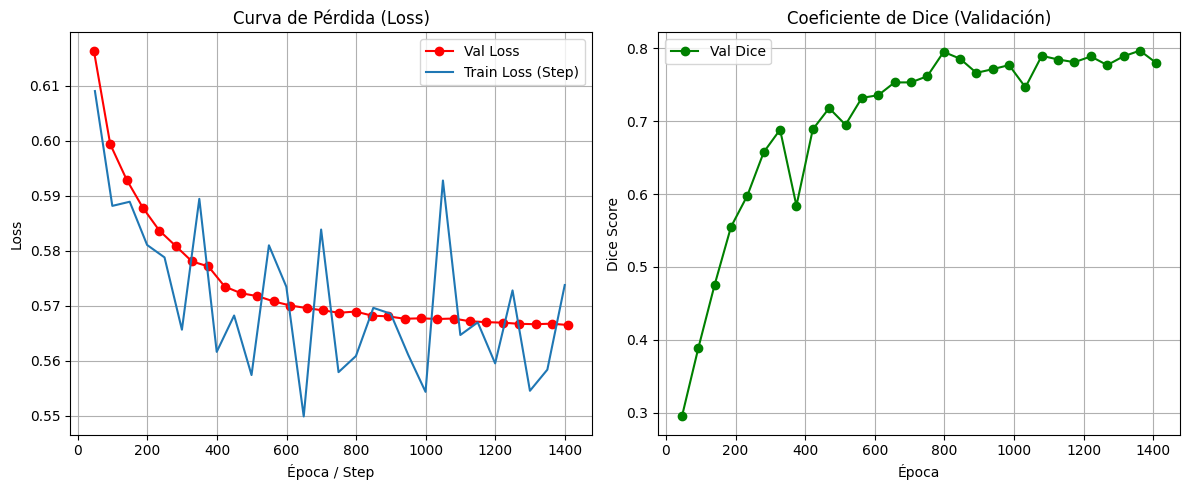

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import glob
import os

# Encontrar la ruta del archivo de eventos
log_dir = sorted(glob.glob("lightning_logs/version_*"))[-1]
events_path = glob.glob(os.path.join(log_dir, "events.out.tfevents.*"))[0]

# Cargar el acumulador de eventos
ea = event_accumulator.EventAccumulator(events_path,
                                        size_guidance={
                                            event_accumulator.SCALARS: 0
                                        })
ea.Reload()

# Extraer las métricas
try:
    # Métricas de validación
    val_loss_events = ea.scalars.Items('val_loss')
    val_dice_events = ea.scalars.Items('val_dice')

    # Pérdida de entrenamiento
    train_loss_events = ea.scalars.Items('train_loss')

    # Convertir a DataFrame
    val_data = {
        'epoch': [e.step for e in val_loss_events],
        'val_loss': [e.value for e in val_loss_events],
        'val_dice': [e.value for e in val_dice_events]
    }
    train_data = {
        'step': [e.step for e in train_loss_events],
        'train_loss': [e.value for e in train_loss_events]
    }

    val_df = pd.DataFrame(val_data)
    train_df = pd.DataFrame(train_data)

    # Graficar Pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # Graficar val_loss vs. epoch
    plt.plot(val_df['epoch'], val_df['val_loss'], label='Val Loss', color='red', marker='o')
    # Graficar train_loss vs. step
    plt.plot(train_df['step'], train_df['train_loss'], label='Train Loss (Step)')
    plt.title('Curva de Pérdida (Loss)')
    plt.xlabel('Época / Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Graficar Métrica
    plt.subplot(1, 2, 2)
    plt.plot(val_df['epoch'], val_df['val_dice'], label='Val Dice', color='green', marker='o')
    plt.title('Coeficiente de Dice (Validación)')
    plt.xlabel('Época')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except KeyError as e:
    print(f"Error al encontrar métrica: {e}. Asegúrese de que la clave de log es correcta.")

In [17]:
def clean_noise(mask, min_area=50):
    """
    Elimina componentes conectados pequeños (ruido) de la máscara binaria.
    """

    if mask.ndim == 3:
        mask = mask.squeeze()

    mask_uint8 = (mask > 0).astype(np.uint8) * 255

    # Encontrar componentes conectados
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, 4, cv2.CV_32S)

    cleaned_mask = np.zeros_like(mask_uint8)

    # Filtrar por área mínima (excluyendo el fondo, i=0)
    if num_labels > 1:
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                cleaned_mask[labels == i] = 1

    return np.expand_dims(cleaned_mask.astype(np.uint8), axis=-1)

In [33]:

best_model_path = '/content/lightning_logs/version_1/checkpoints/best_model-epoch=28-val_dice=0.7970.ckpt'
print(f"Cargando mejor modelo: {best_model_path}")

model_final = BrainTumorModel.load_from_checkpoint(
    best_model_path,
    backbone='efficientnet-b0',
    lr=1e-4
)

# Definir el DataLoader de prueba
test_torch_dataset = FullImageDataset(test_coco, test_dir, test_ids, augmentations=None)
test_loader = DataLoader(
    test_torch_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=False,
    pin_memory=True
)

test_trainer = pl.Trainer(accelerator='gpu', devices=1, precision='16-mixed')

print("\nIniciando Evaluación Oficial...")
results = test_trainer.test(model_final, dataloaders=test_loader)
print("\n--- RESULTADOS FINALES ---")
print(results)

Cargando mejor modelo: /content/lightning_logs/version_1/checkpoints/best_model-epoch=28-val_dice=0.7970.ckpt


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Iniciando Evaluación Oficial...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.7816328406333923     │
│         test_loss         │    0.5674996376037598     │
└───────────────────────────┴───────────────────────────┘


--- RESULTADOS FINALES ---
[{'test_loss': 0.5674996376037598, 'test_dice': 0.7816328406333923}]


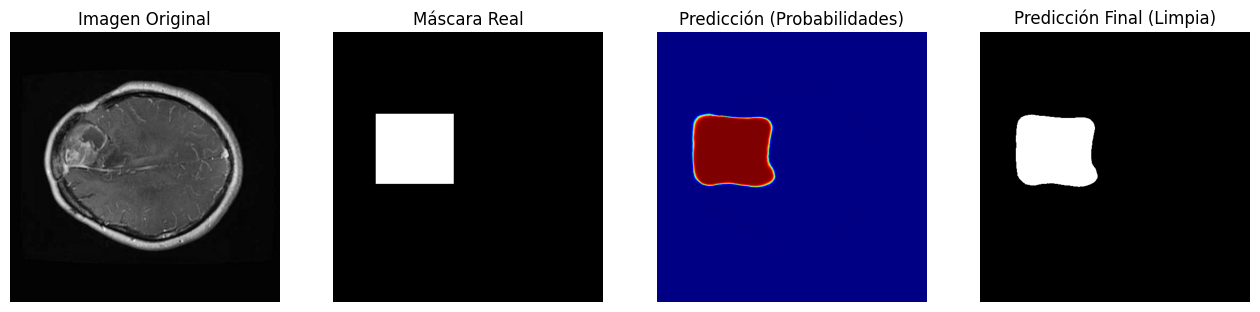

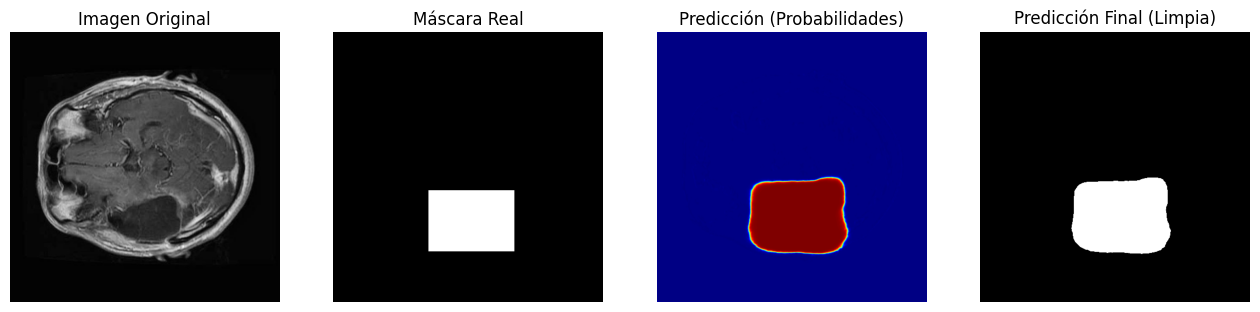

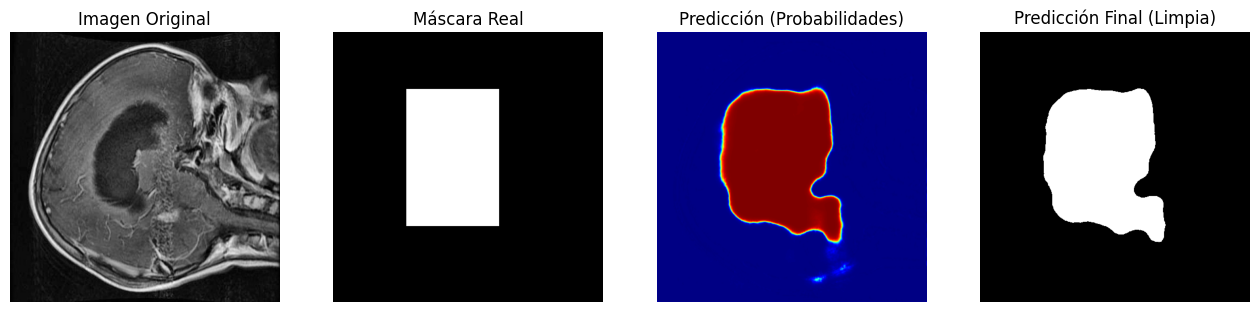

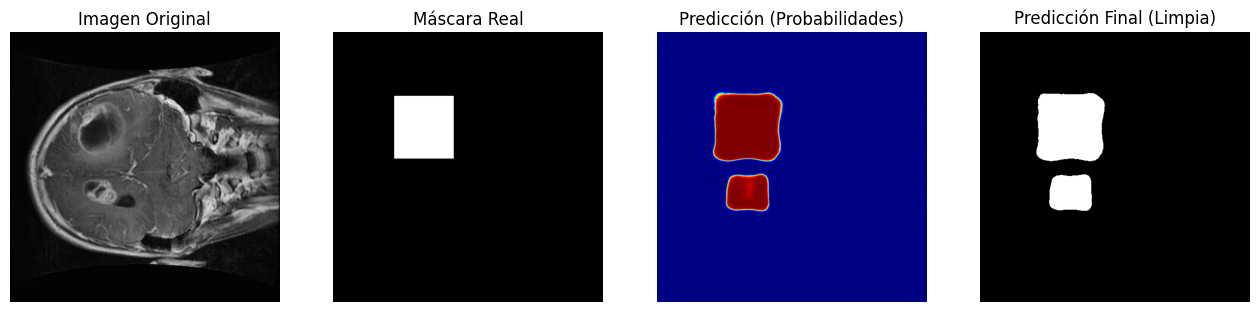

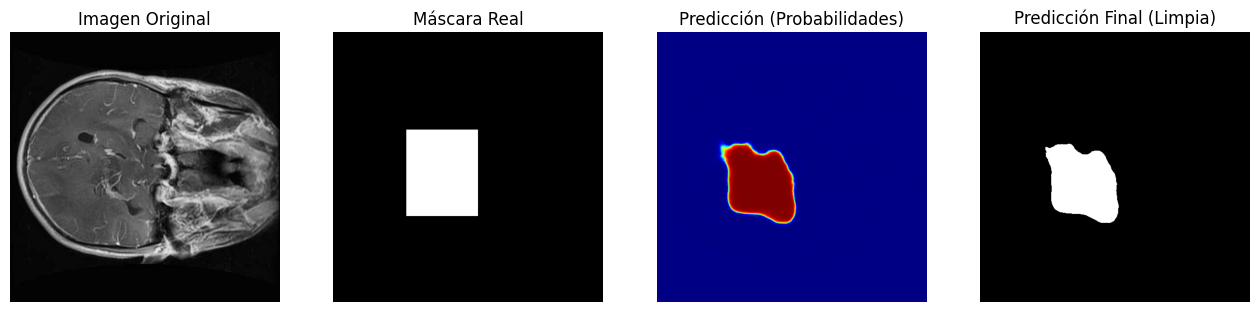

In [19]:
# Asumiendo que 'model_final' está cargado de la Celda 11
# y la Celda 10 (clean_noise) fue ejecutada

def visualize_results(model, data_loader, num_samples=3):
    model.eval() # Poner el modelo en modo evaluación
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tomar 3 muestras para visualización
    sample_loader = DataLoader(
        test_torch_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    with torch.no_grad():
        for i, (img, mask_true) in enumerate(sample_loader):
            if i >= num_samples:
                break

            img = img.to(device)

            # 1. Inferencia (Full Image)
            mask_pred_raw = model(img).cpu().numpy().squeeze() # Output (H, W) float 0-1

            # 2. Umbral y Post-procesamiento
            mask_pred_binary = (mask_pred_raw > 0.5).astype(np.uint8)
            mask_pred_cleaned = clean_noise(mask_pred_binary, min_area=50).squeeze()

            # Convertir la entrada y la máscara real a formato (H, W, C) para Matplotlib
            img_np = np.transpose(img.cpu().numpy().squeeze(), (1, 2, 0))
            mask_true_np = mask_true.numpy().squeeze()

            # 3. Visualizar
            plt.figure(figsize=(16, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(img_np)
            plt.title("Imagen Original")
            plt.axis("off")

            plt.subplot(1, 4, 2)
            plt.imshow(mask_true_np, cmap="gray")
            plt.title("Máscara Real")
            plt.axis("off")

            plt.subplot(1, 4, 3)
            plt.imshow(mask_pred_raw, cmap="jet")
            plt.title("Predicción (Probabilidades)")
            plt.axis("off")

            plt.subplot(1, 4, 4)
            plt.imshow(mask_pred_cleaned, cmap="gray")
            plt.title("Predicción Final (Limpia)")
            plt.axis("off")

            plt.show()

# Ejecutar visualización
visualize_results(model_final, test_loader, num_samples=5)